In [2]:
import yfinance as yf
import pandas as pd

# Define tickers and time range
tickers = ['XLK', 'SMH']
data = yf.download(tickers, start="2015-01-01", end="2024-12-31")['Close'].dropna()
data.columns = ['Tech_ETF', 'Semiconductor_ETF']

# Save for analysis
data.to_csv("xlk_smh_prices.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


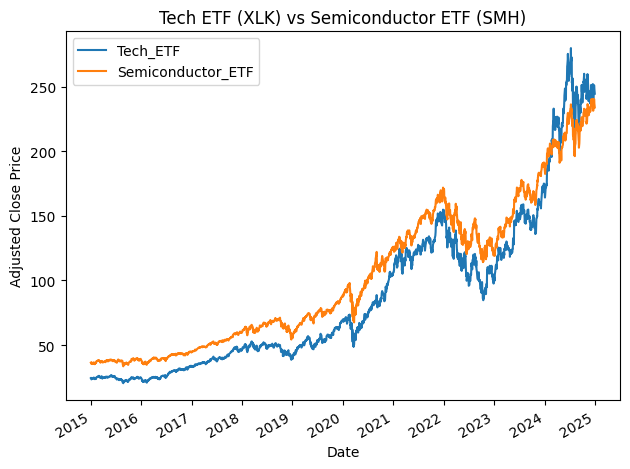

XLK ADF Statistic: 1.0237
XLK p-value: 0.9945
SMH ADF Statistic: 1.2420
SMH p-value: 0.9963
[5.73246137 0.3924754 ]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation Tech_ETF 
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0585      0.125     -0.469      0.639      -0.303       0.186
L1.Tech_ETF             -0.0257      0.041     -0.621      0.535      -0.107       0.055
L1.Semiconductor_ETF    -0.0847      0.055     -1.552      0.121      -0.192       0.022
Det. terms outside the coint. relation & lagged endog. parameters for equation Semiconductor_ETF
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0606      0.095      0.640      0.522      -0.125       0.246
L1.Tech_ETF              0.0523      0.031      1.662      0.096      -0.009       0.114
L1.Semiconduc

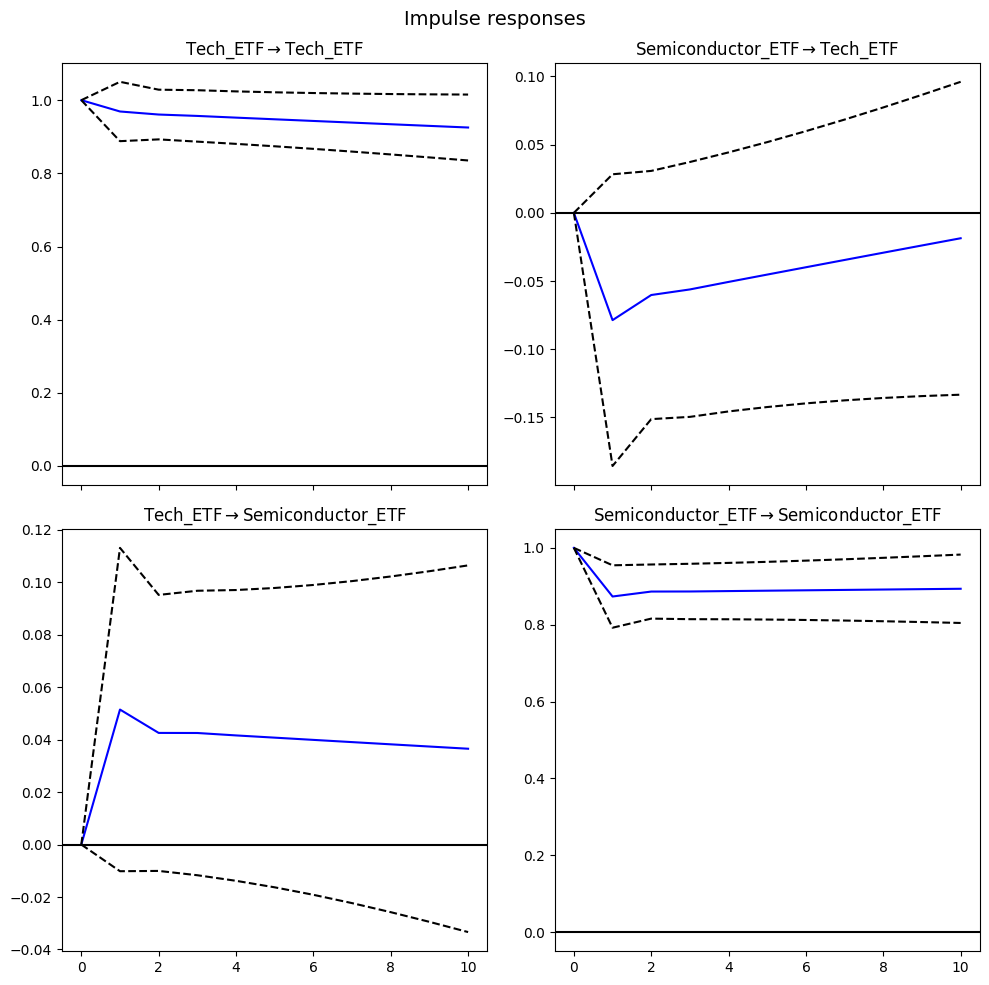

In [4]:

import matplotlib.pyplot as plt
df = pd.read_csv("xlk_smh_prices.csv", parse_dates=["Date"], index_col="Date")

# Plot
df.plot(title="Tech ETF (XLK) vs Semiconductor ETF (SMH)", ylabel="Adjusted Close Price")
plt.tight_layout()
plt.savefig("xlk_smh_prices.png")
plt.show()

from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series)
    print(f"{name} ADF Statistic: {result[0]:.4f}")
    print(f"{name} p-value: {result[1]:.4f}")
    return result[1]

adf_test(df['Tech_ETF'], "XLK")
adf_test(df['Semiconductor_ETF'], "SMH")
#If both p-values are above 0.05, the series are non-stationary.


from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen test
johan_test = coint_johansen(df, det_order=0, k_ar_diff=1)
print(johan_test.lr1)  # Trace statistics
print(johan_test.cvt)  # Critical values
#A trace statistic above the 95% critical value implies cointegration.


from statsmodels.tsa.vector_ar.vecm import VECM

# Fit VECM
vec_model = VECM(df, k_ar_diff=1, coint_rank=1, deterministic="co")
vec_res = vec_model.fit()
print(vec_res.summary())
#The error correction term captures how deviations from equilibrium influence future price movements.


irf = vec_res.irf(10)
irf.plot(orth=False)
plt.tight_layout()
plt.savefig("vecm_irf.png")
plt.show()


In [5]:
!pip install pyinform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 8.4 MB/s eta 0:00:00


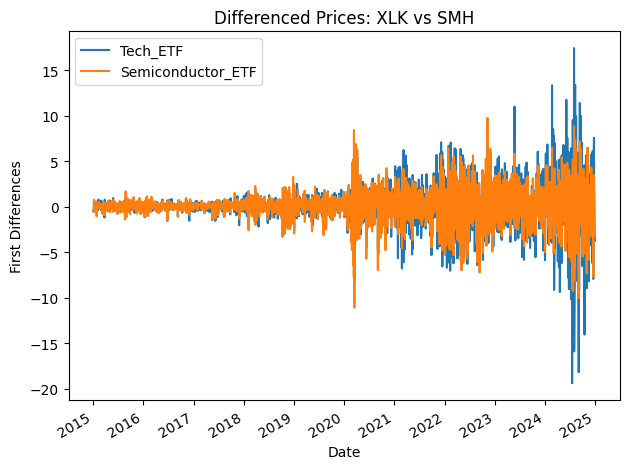

Transfer Entropy SMH → XLK: 0.0205
Transfer Entropy XLK → SMH: 0.0190


In [6]:
import pandas as pd
import numpy as np
import pyinform.transferentropy as te
import matplotlib.pyplot as plt

# Load your differenced dataset
df = pd.read_csv("xlk_smh_prices.csv", parse_dates=["Date"], index_col="Date")
df_diff = df.diff().dropna()

# Optional: Plot differenced series
df_diff.plot(title="Differenced Prices: XLK vs SMH", ylabel="First Differences")
plt.tight_layout()
plt.show()

# Step 1: Discretize the data (e.g., 3 bins: down, steady, up)
def discretize(series, bins=3):
    return pd.qcut(series.rank(method="first"), bins, labels=False)

# Discretize both series
xlk_disc = discretize(df_diff['Tech_ETF']).astype(int).values
smh_disc = discretize(df_diff['Semiconductor_ETF']).astype(int).values

# pyinform expects shape (trials, length) → reshape to (1, len)
xlk_series = xlk_disc.reshape(1, -1)
smh_series = smh_disc.reshape(1, -1)

# Compute Transfer Entropy (lag 1)
te_smh_to_xlk = te.transfer_entropy(smh_series, xlk_series, k=1)
te_xlk_to_smh = te.transfer_entropy(xlk_series, smh_series, k=1)

print(f"Transfer Entropy SMH → XLK: {te_smh_to_xlk:.4f}")
print(f"Transfer Entropy XLK → SMH: {te_xlk_to_smh:.4f}")


100%|██████████| 2414/2414 [00:07<00:00, 337.99it/s]


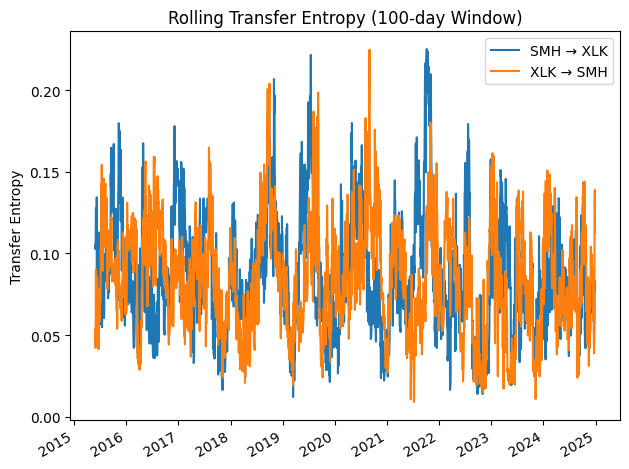

In [7]:
import pandas as pd
import numpy as np
import pyinform.transferentropy as te
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and difference
df = pd.read_csv("xlk_smh_prices.csv", parse_dates=["Date"], index_col="Date")
df_diff = df.diff().dropna()

# Parameters
window = 100
bins = 3

# Discretization function
def discretize(series, bins=3):
    return pd.qcut(series.rank(method="first"), bins, labels=False)

# Rolling TE storage
te_smh_to_xlk = []
te_xlk_to_smh = []
dates = []

# Rolling TE computation
for i in tqdm(range(window, len(df_diff))):
    sub = df_diff.iloc[i - window:i]
    xlk_disc = discretize(sub['Tech_ETF'], bins).astype(int).values.reshape(1, -1)
    smh_disc = discretize(sub['Semiconductor_ETF'], bins).astype(int).values.reshape(1, -1)
    try:
        te1 = te.transfer_entropy(smh_disc, xlk_disc, k=1)
        te2 = te.transfer_entropy(xlk_disc, smh_disc, k=1)
    except Exception:
        te1, te2 = np.nan, np.nan
    te_smh_to_xlk.append(te1)
    te_xlk_to_smh.append(te2)
    dates.append(sub.index[-1])

# Create DataFrame
te_df = pd.DataFrame({
    "SMH → XLK": te_smh_to_xlk,
    "XLK → SMH": te_xlk_to_smh
}, index=pd.to_datetime(dates))

# Plot
te_df.plot(title="Rolling Transfer Entropy (100-day Window)")
plt.ylabel("Transfer Entropy")
plt.tight_layout()
plt.savefig("rolling_transfer_entropy.png")
plt.show()


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Use the rolling TE values as features
features = pd.DataFrame(index=te_df.index)
features["TE_SMH_to_XLK"] = te_df["SMH → XLK"]
features["TE_XLK_to_SMH"] = te_df["XLK → SMH"]

# Add lagged SMH returns as a predictor
df_ret = df.diff().dropna().pct_change().dropna()
features["SMH_Return"] = df_ret.loc[features.index, "Semiconductor_ETF"]

# Target: XLK return
target = df_ret.loc[features.index, "Tech_ETF"]

# Combine features and target
data = pd.concat([features, target.rename("XLK_Return")], axis=1)

# Drop rows with NaN, Inf, or -Inf
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Train/test split
train = data.iloc[:-200]
test = data.iloc[-200:]

# Fit linear model
model = LinearRegression()
model.fit(train.drop("XLK_Return", axis=1), train["XLK_Return"])

# Predict
y_pred = model.predict(test.drop("XLK_Return", axis=1))

# Evaluation
r2 = r2_score(test["XLK_Return"], y_pred)
rmse = mean_squared_error(test["XLK_Return"], y_pred)

print(f"Test R²: {r2:.4f}, RMSE: {rmse:.6f}")


Test R²: -0.0009, RMSE: 237.814801


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop("XLK_Return", axis=1))
y_scaled = scaler.fit_transform(data[["XLK_Return"]])

# Train/test split
X_train, X_test = X_scaled[:-200], X_scaled[-200:]
y_train, y_test = y_scaled[:-200], y_scaled[-200:]

model = LinearRegression()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")


R²: -0.0009, RMSE: 0.6249


In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train, y_train.ravel())
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest R²: {r2_rf:.4f}, RMSE: {rmse_rf:.4f}")


Random Forest R²: -0.0493, RMSE: 0.6551


SMH → XLK: 0.0205
XLK → SMH: 0.0190


100%|██████████| 2414/2414 [00:06<00:00, 349.77it/s]


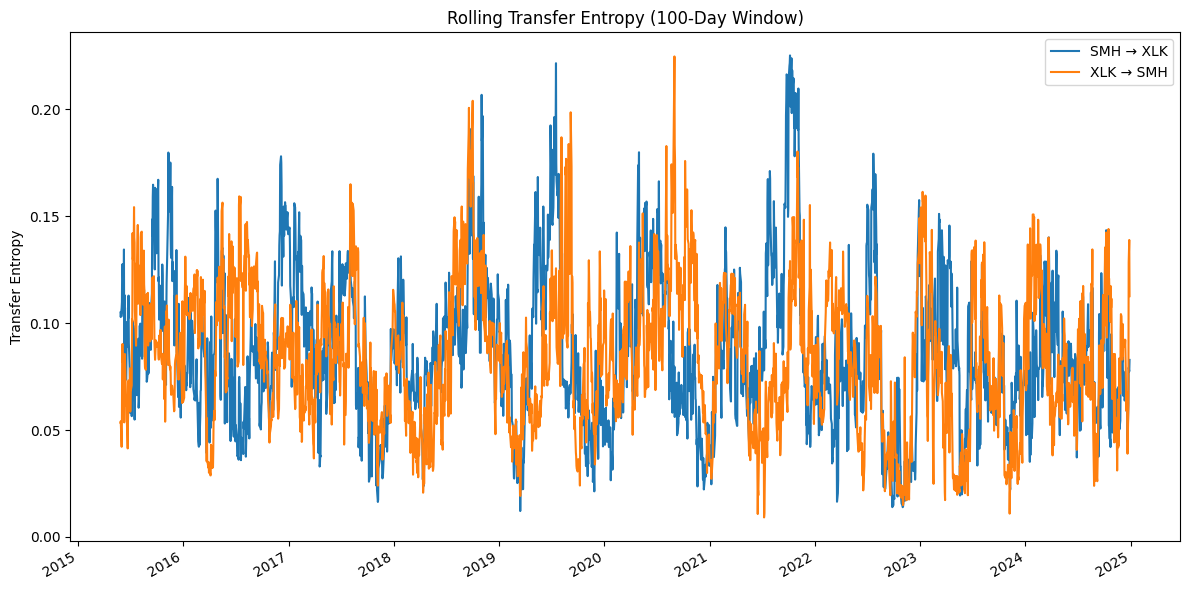

In [14]:

import pandas as pd
import numpy as np
import pyinform.transferentropy as te
import matplotlib.pyplot as plt

# Load your differenced data
df = pd.read_csv("xlk_smh_prices.csv", parse_dates=["Date"], index_col="Date")
df_diff = df.diff().dropna()

# Discretize into 3 states
def discretize(series, bins=3):
    return pd.qcut(series.rank(method="first"), bins, labels=False)

xlk_disc = discretize(df_diff['Tech_ETF']).astype(int).values.reshape(1, -1)
smh_disc = discretize(df_diff['Semiconductor_ETF']).astype(int).values.reshape(1, -1)

# Static TE
te_smh_to_xlk = te.transfer_entropy(smh_disc, xlk_disc, k=1)
te_xlk_to_smh = te.transfer_entropy(xlk_disc, smh_disc, k=1)

print(f"SMH → XLK: {te_smh_to_xlk:.4f}")
print(f"XLK → SMH: {te_xlk_to_smh:.4f}")

from tqdm import tqdm

window = 100
bins = 3
te_smh_to_xlk = []
te_xlk_to_smh = []
dates = []

for i in tqdm(range(window, len(df_diff))):
    sub = df_diff.iloc[i - window:i]
    xlk = discretize(sub['Tech_ETF'], bins).astype(int).values.reshape(1, -1)
    smh = discretize(sub['Semiconductor_ETF'], bins).astype(int).values.reshape(1, -1)
    try:
        te1 = te.transfer_entropy(smh, xlk, k=1)
        te2 = te.transfer_entropy(xlk, smh, k=1)
    except:
        te1, te2 = np.nan, np.nan
    te_smh_to_xlk.append(te1)
    te_xlk_to_smh.append(te2)
    dates.append(sub.index[-1])

# Build the DataFrame
te_df = pd.DataFrame({
    "SMH → XLK": te_smh_to_xlk,
    "XLK → SMH": te_xlk_to_smh
}, index=pd.to_datetime(dates))

te_df.plot(title="Rolling Transfer Entropy (100-Day Window)", figsize=(12, 6))
plt.ylabel("Transfer Entropy")
plt.tight_layout()
plt.savefig("rolling_transfer_entropy.png")
plt.show()

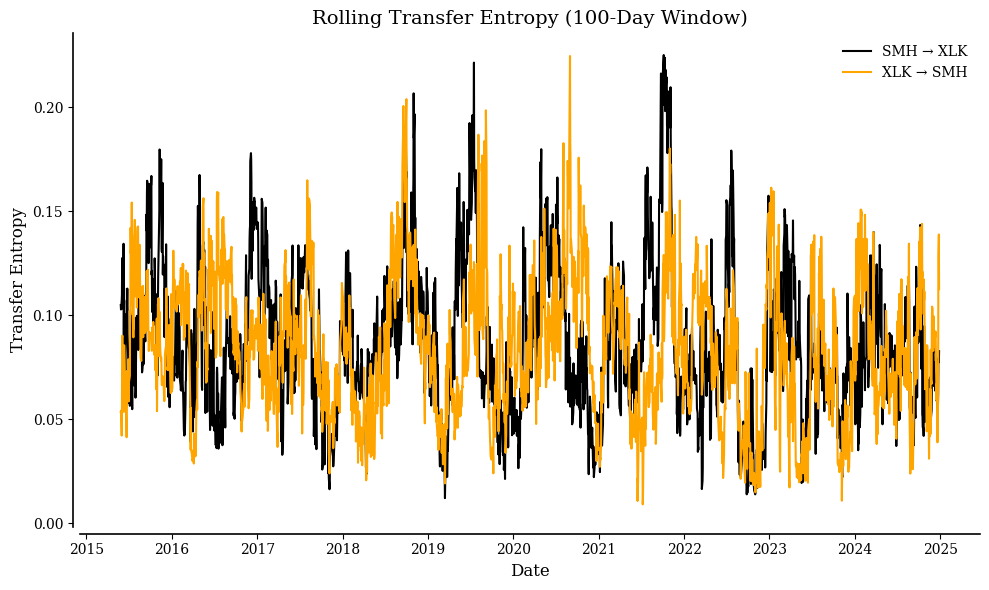

In [18]:
import matplotlib.pyplot as plt

# Minimalist style settings
plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

# Extend spines slightly outward
def adjust_spines(ax):
    ax.spines["left"].set_position(("outward", 5))
    ax.spines["bottom"].set_position(("outward", 5))
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

# Create the minimalist TE plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(te_df.index, te_df["SMH → XLK"], label="SMH → XLK", color="black")
ax.plot(te_df.index, te_df["XLK → SMH"], label="XLK → SMH", color="orange")

adjust_spines(ax)
ax.set_title("Rolling Transfer Entropy (100-Day Window)", fontsize=14)
ax.set_ylabel("Transfer Entropy", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig("rolling_transfer_entropy_minimalist.png")
plt.show()


100%|██████████| 2414/2414 [00:07<00:00, 315.43it/s]


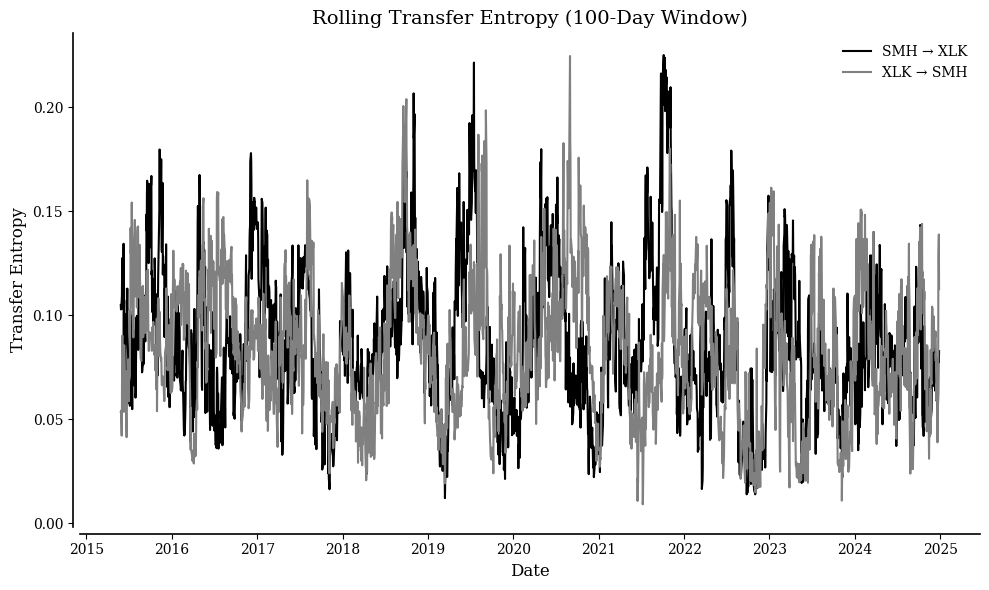

In [19]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt

# Reload TE results from rolling computation
file_path = "xlk_smh_prices.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
df_diff = df.diff().dropna()

# Discretization
def discretize(series, bins=3):
    return pd.qcut(series.rank(method="first"), bins, labels=False)

import numpy as np
import pyinform.transferentropy as te
from tqdm import tqdm

window = 100
bins = 3
te_smh_to_xlk = []
te_xlk_to_smh = []
dates = []

for i in tqdm(range(window, len(df_diff))):
    sub = df_diff.iloc[i - window:i]
    xlk = discretize(sub['Tech_ETF'], bins).astype(int).values.reshape(1, -1)
    smh = discretize(sub['Semiconductor_ETF'], bins).astype(int).values.reshape(1, -1)
    try:
        te1 = te.transfer_entropy(smh, xlk, k=1)
        te2 = te.transfer_entropy(xlk, smh, k=1)
    except:
        te1, te2 = np.nan, np.nan
    te_smh_to_xlk.append(te1)
    te_xlk_to_smh.append(te2)
    dates.append(sub.index[-1])

# Create TE DataFrame
te_df = pd.DataFrame({
    "SMH → XLK": te_smh_to_xlk,
    "XLK → SMH": te_xlk_to_smh
}, index=pd.to_datetime(dates))

# Apply minimalist style for plotting
plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

def adjust_spines(ax):
    ax.spines["left"].set_position(("outward", 5))
    ax.spines["bottom"].set_position(("outward", 5))
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(te_df.index, te_df["SMH → XLK"], label="SMH → XLK", color="black")
ax.plot(te_df.index, te_df["XLK → SMH"], label="XLK → SMH", color="gray")

adjust_spines(ax)
ax.set_title("Rolling Transfer Entropy (100-Day Window)", fontsize=14)
ax.set_ylabel("Transfer Entropy", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig("rolling_transfer_entropy_minimalist.png")
plt.show()


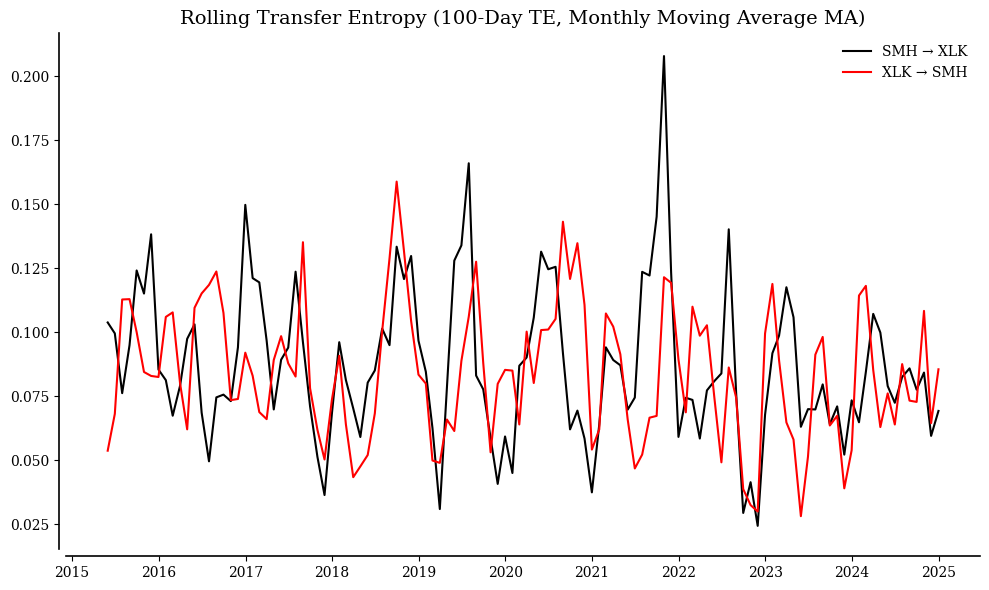

In [25]:
# Apply smoothing
te_df_smooth = te_df.resample("ME").mean()

# Minimalist plot
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

def adjust_spines(ax):
    ax.spines["left"].set_position(("outward", 5))
    ax.spines["bottom"].set_position(("outward", 5))
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(te_df_smooth.index, te_df_smooth["SMH → XLK"], label="SMH → XLK", color="black")
ax.plot(te_df_smooth.index, te_df_smooth["XLK → SMH"], label="XLK → SMH", color="red")

adjust_spines(ax)
ax.set_title("Rolling Transfer Entropy (100-Day TE, Monthly Moving Average MA)", fontsize=14)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig("rolling_transfer_entropy_smoothed.png")
plt.show()
